In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics
os.chdir("..")
os.getcwd()

from platform import python_version
print(python_version())

import importlib.util

spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src/data_prep.py")
#spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src\\data_prep.py")
prep_data = importlib.util.module_from_spec(spec_data_pred)
spec_data_pred.loader.exec_module(prep_data)

spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src/plotting_printing.py")
#spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src\\plotting_printing.py")
plotting_printing = importlib.util.module_from_spec(spec_plotting_printing)
spec_plotting_printing.loader.exec_module(plotting_printing)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)


3.8.10


### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using Cifar10 data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### logscaling, all epochs: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [2]:
model_type = "log_scaling_all_epochs"

In [3]:
#results_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_20230705.csv")
##results_val_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_val_20230708.csv")
#results_4500_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jelena_batch_size_512_mixture_design_maximin_subsetsize_4500_20230715.csv")

results_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jf_batch_size_512_reset_fc_output_size_mixture_design_maximin_20230927.csv")
results_val_from_file = pd.read_csv("csv_files/Cifar10_val_acc_subsets_thomas_batch_size_512_reset_fc_output_size_mixture_design_maximin_20231103.csv")
# the following may need to be recalculated?
results_4500_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jelena_batch_size_512_mixture_design_maximin_subsetsize_4500_20230715.csv")

#prep_data

data_dict = prep_data.prep_data_all_epochs(results_from_file, 
              results_val_from_file, 
              results_4500_from_file, 
              min_epoch = 20)

# the following unacks all dict items into a corresonding variable:
locals().update(data_dict)

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &  accs &  plane &   car &  bird &    cat &  deer &    dog &   frog &   horse &   ship &  truck &  epochs\_trained &  total\_training\_size \\
\midrule
0 &  0.37 & 888.00 & 99.00 & 93.00 & 459.00 & 93.00 & 674.00 & 351.00 & 1257.00 & 541.00 & 545.00 &              20 &              5000.00 \\
1 &  0.39 & 888.00 & 99.00 & 93.00 & 459.00 & 93.00 & 674.00 & 351.00 & 1257.00 & 541.00 & 545.00 &              25 &              5000.00 \\
2 &  0.32 & 888.00 & 99.00 & 93.00 & 459.00 & 93.00 & 674.00 & 351.00 & 1257.00 & 541.00 & 545.00 &              30 &              5000.00 \\
3 &  0.40 & 888.00 & 99.00 & 93.00 & 459.00 & 93.00 & 674.00 & 351.00 & 1257.00 & 541.00 & 545.00 &              35 &              5000.00 \\
4 &  0.42 & 888.00 & 99.00 & 93.00 & 459.00 & 93.00 & 674.00 & 351.00 & 1257.00 & 541.00 & 545.00 &              40 &              5000.00 \\
\bottomrule
\

,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


(12, 10800)


,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


# full linear option

### Full option: 

* Fit a model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [4]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a * np.log(d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + b) + c

np.random.seed(seed=4213523)
p0 = np.random.uniform(low=0, high=1, size = 14)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch
param_value,0.297096,0.597273,0.299175,0.377698,0.509008,0.441412,0.493104,0.665955,0.343094,0.571452,0.615925,0.487999,0.610697,1.124883


\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch \\
\midrule
param\_value & 0.30 & 0.60 & 0.30 &   0.38 & 0.51 &  0.44 & 0.49 &  0.67 & 0.34 &  0.57 &   0.62 &  0.49 &   0.61 &   1.12 \\
\bottomrule
\end{tabular}

0.0020998013238251343


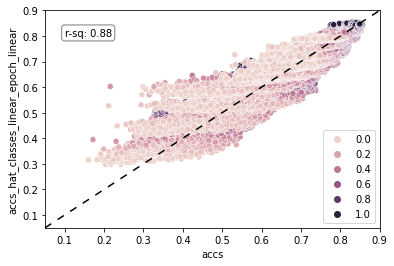

0.8795753856418568
mean val loss: 0.00228799366852628


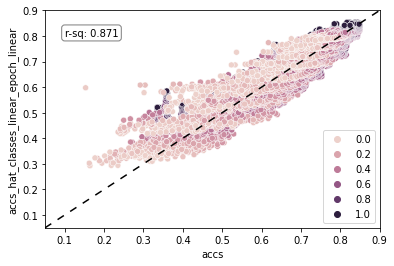

r_square val: 0.8705777099658405


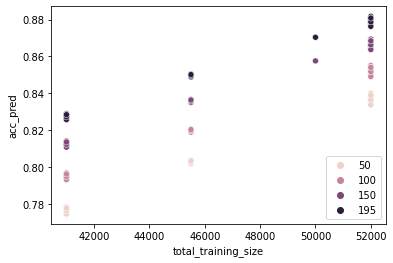

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.870377
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.857537
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.849030
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.835212
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.819064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.836526
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.880806
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.868419
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.854021


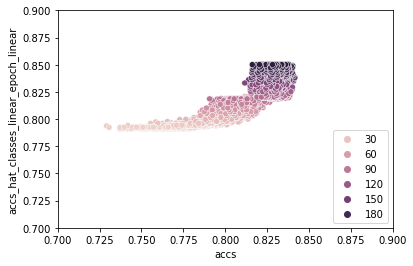

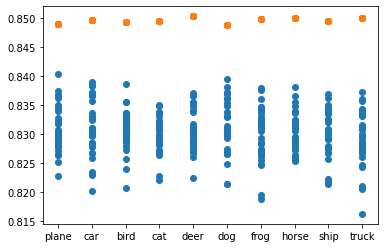

In [5]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch"]
if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False)

In [6]:
# mask = results_4500_orig.epochs_trained == 40
# plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask]["accs"], label= "accs")
# plt.scatter(x=results_4500[mask]["class"], y = results_4500[mask][y_hat_name], label= "accs pred")
# plt.show()


### Using an arctan effect for epoch only, but linear for classes:

In [7]:
y_hat_name = "accs_hat_classes_linear_epoch_arctan"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a * np.log(d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*np.arctan(d_epoch_2 * epochs_trained) + b) + c


np.random.seed(seed=42135230)
p0 = np.random.uniform(low=0, high=1, size = 15)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")




param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch_2
param_value,0.346236,0.739655,0.150059,0.424358,0.573581,0.508621,0.553736,0.73651,0.389611,0.639046,0.682562,0.544321,0.675781,1.063209,5.069621


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch\_2 \\
\midrule
param\_value & 0.35 & 0.74 & 0.15 &   0.42 & 0.57 &  0.51 & 0.55 &  0.74 & 0.39 &  0.64 &   0.68 &  0.54 &   0.68 &   1.06 &     5.07 \\
\bottomrule
\end{tabular}

0.0017735691759999525


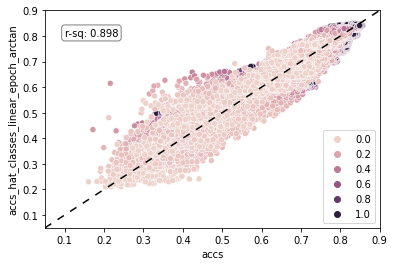

0.8982849559937365
mean val loss: 0.001970058727186299


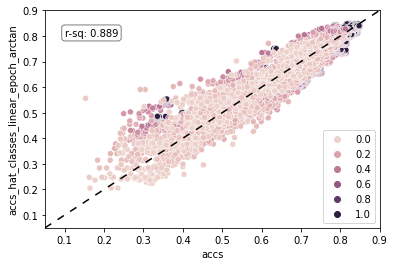

r_square val: 0.8885619678578653


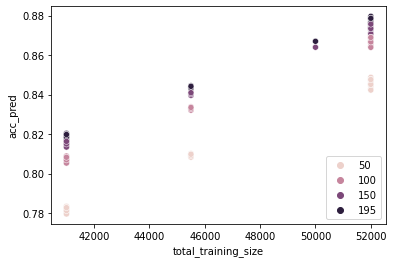

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.867044
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.864024
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.843066
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.839828
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.832326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.845235
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.878650
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.875730
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.868974


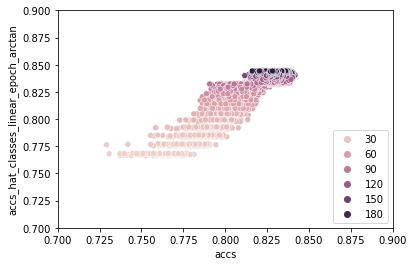

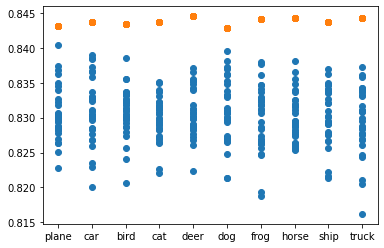

In [8]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "epoch_2"]
if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False)

### using an arctan effect for every class:

In [9]:
y_hat_name = "accs_hat_classes_arctan_epoch_artan"

def func(x, a: float, b: float, c: float, d0:float, d0_2:float, d1:float, d1_2:float, d2:float, d2_2:float, d3:float, d3_2:float, d4:float, d4_2:float, d5:float, d5_2:float, d6:float, d6_2:float, d7:float, d7_2:float, d8:float, d8_2:float, d9:float, d9_2:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a * np.log(d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained) + b) +  c

np.random.seed(seed=42135230)
n_p = 25
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 50))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,plane_1,plane_2,car_1,car_2,bird_1,bird_2,cat_1,cat_2,deer_1,deer_2,dog_1,dog_2,frog_1,frog_2,horse_1,horse_2,ship_1,ship_2,truck_1,truck_2,epoch_1,epoch_2
param_value,12.007507,1.029847,-0.343953,0.003877,12.879692,0.004529,15.369205,0.003684,6.003838,0.003015,4.616334,0.004303,6.074731,0.00336,9.673026,0.004673,19.114522,0.004433,9.987736,0.005075,29.222001,0.004664,21.345022,0.009418,6.312078


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &     c &  plane\_1 &  plane\_2 &  car\_1 &  car\_2 &  bird\_1 &  bird\_2 &  cat\_1 &  cat\_2 &  deer\_1 &  deer\_2 &  dog\_1 &  dog\_2 &  frog\_1 &  frog\_2 &  horse\_1 &  horse\_2 &  ship\_1 &  ship\_2 &  truck\_1 &  truck\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\_value & 12.01 & 1.03 & -0.34 &     0.00 &    12.88 &   0.00 &  15.37 &    0.00 &    6.00 &   0.00 &   4.62 &    0.00 &    6.07 &   0.00 &   9.67 &    0.00 &   19.11 &     0.00 &     9.99 &    0.01 &   29.22 &     0.00 &    21.35 &     0.01 &     6.31 \\
\bottomrule
\end{tabular}

0.0006060321584524225


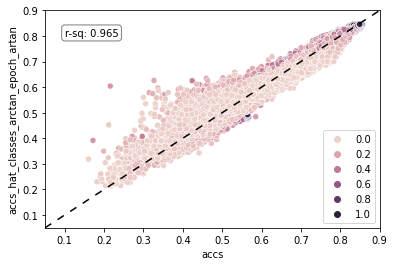

0.9652437646637355
mean val loss: 0.000684087650109655


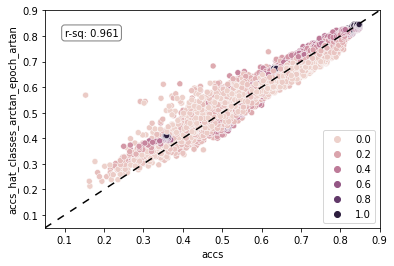

r_square val: 0.9613040055664553


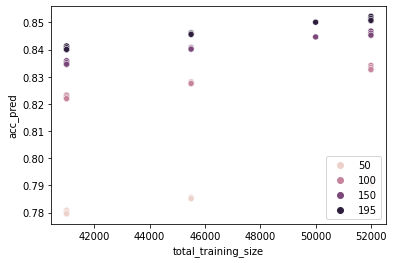

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.850109
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.844682
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.845741
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.840312
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.827651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.790207
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.850787
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.845360
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.832705


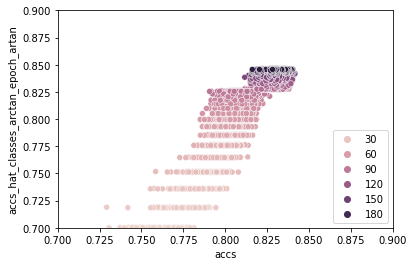

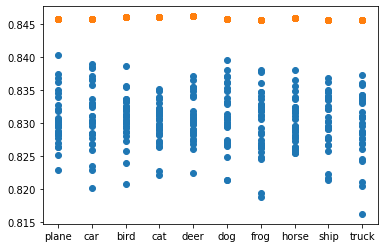

param_value           
param_no           1          2
feature                        
bird        0.003684   6.003838
car         0.004529  15.369205
cat         0.003015   4.616334
deer        0.004303   6.074731
dog         0.003360   9.673026
epoch       0.009418   6.312078
frog        0.004673  19.114522
horse       0.004433   9.987736
plane       0.003877  12.879692
ship        0.005075  29.222001
truck       0.004664  21.345022

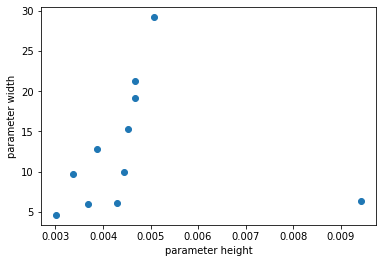

In [10]:
param_names = ["a", "b", "c"]
for c in classes:
    param_names = param_names + [f"{c}_1", f"{c}_2"]
param_names = param_names + ["epoch_1", "epoch_2"]
if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=True)


# all class counts linear, but including quadratic term for epoch:

In [11]:
y_hat_name = "accs_hat_classes_linear_epoch_sq"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epochs_sq:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a * np.log((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2) + b) + c

np.random.seed(seed=421324576)
n_p = 15
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")


param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch**2
param_value,0.335148,0.434031,0.355951,0.24836,0.335468,0.296165,0.324187,0.432593,0.227337,0.374495,0.400608,0.319278,0.396694,2.138471,-1.45872


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch**2 \\
\midrule
param\_value & 0.34 & 0.43 & 0.36 &   0.25 & 0.34 &  0.30 & 0.32 &  0.43 & 0.23 &  0.37 &   0.40 &  0.32 &   0.40 &   2.14 &     -1.46 \\
\bottomrule
\end{tabular}

0.0017870370454865102


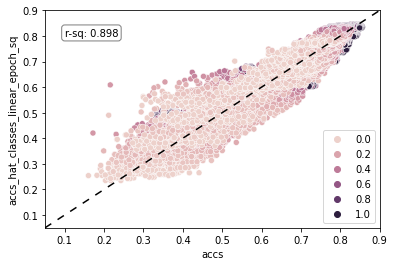

0.897512567210692
mean val loss: 0.0019806121478993756


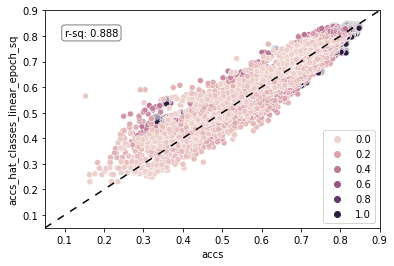

r_square val: 0.8879650047214857


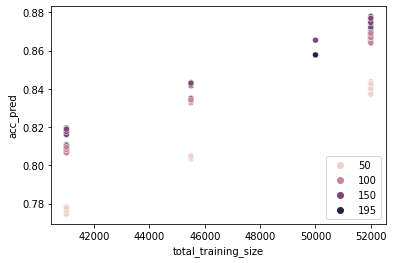

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.857736
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.865435
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.833574
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.841841
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.833009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.840182
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.869431
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.876869
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.868924


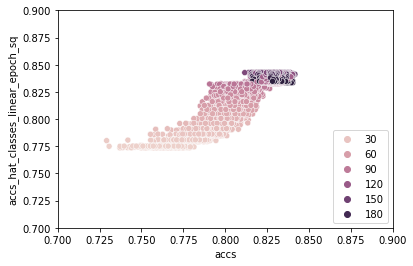

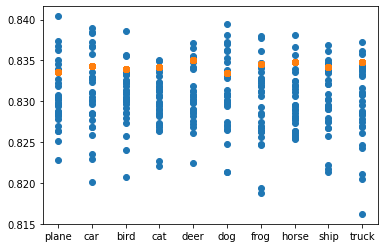

In [12]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "epoch**2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False)
